In [1]:
from pymongo import MongoClient
import requests
import geopandas as gdp
from cartoframes.viz import Map, Layer, popup_element
import folium
from getpass import getpass
import json
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import src.extration as ext
import src.transformation as tran
import src.visualization as visu
import src.four_square as fsquare

# 1. Extraction of the data

In [2]:
#extration ----------------------------------------
# Connection to mongo  
client = MongoClient("localhost:27017")
client.list_database_names()
db = client["ironhack"]
c = db.get_collection("companies")

ext.counting_companies_in_a_category("desing")
ext.create_df_filtered_companies_and_export()

Total number companies of desing is 0
exported


# Transforming

#### The data got in MongoDB

In [3]:
df = pd.read_csv('data/filter_companies.csv')
# Creating a data frame with just the city and a count of companies in each city
city_df = df.groupby('city')['name'].count().reset_index()
city_df.columns = ['City', 'Companies']

# # Creating a data frame with just the city and a count of companies with 'gam' in category code in each city 
game_companies = df[df['category_code'].str.lower().str.contains('gam')]
game_df = game_companies.groupby('city')['name'].count().reset_index()
game_df.columns = ['City', 'Game Companies']

# The results on this data frame have the city, the count of companies and the count of company with Category Code containing 'gam'
merged = pd.merge(city_df, game_df, on='City').sort_values("Companies", ascending=False)
merged.head(10) # with this it was decided the city to our company --> 'San Francisco'

,City,Companies,Game Companies
17,San Francisco,95,8
12,New York,68,5
8,London,37,1
20,Seattle,31,3
13,Palo Alto,20,2
9,Los Angeles,17,1
18,San Mateo,17,1
24,Sunnyvale,16,1
2,Boston,15,2
3,Cambridge,13,1


# Using Four Square API

In [4]:
password = getpass
password = getpass()

### Deciced the city now want to decide the neighborhood

**Given the neighborhood and a random coordinate**

In [5]:
neighborhood_coordinates = {
    'Chinatown': {'Latitude': 37.7941, 'Longitude': -122.4078},
    'North Beach': {'Latitude': 37.8010, 'Longitude': -122.4092},
    'Mission District': {'Latitude': 37.7599, 'Longitude': -122.4148},
    'Nob Hill': {'Latitude': 37.7934, 'Longitude': -122.4156},
    'Haight-Ashbury': {'Latitude': 37.7700, 'Longitude': -122.4452},
    'SoMa (South of Market)': {'Latitude': 37.7783, 'Longitude': -122.4093},
    'Marina District': {'Latitude': 37.8002, 'Longitude': -122.4392},
    'Pacific Heights': {'Latitude': 37.7925, 'Longitude': -122.4392},
    'Sunset District': {'Latitude': 37.7559, 'Longitude': -122.4753},
    'Castro District': {'Latitude': 37.7616, 'Longitude': -122.4355}
}

**Creating a data frame to analysis all criteas**

In [6]:
# Searching Starbucks
df_starbucks = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password,  query = "starbucks", radius=500)
# Searching Airport
df_airport = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password, query = "airport", radius = 5000)
# # Searching Pub
df_pub = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password, query = "pub", radius=100)
# Searching Vegan Restaurants
df_vegan_restaurants = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates,password = password, query = "vegan_restaurants", radius=500)
# # Searching School
df_school = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password, query = "kids_school", radius=2000)
# Searching Basketball Stadium
df_basketball_stadium = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password, query = "basketball_stadium", radius=1000)
# Searching Dog Hairddresser
df_dog_hairddresser = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates,password = password, query = "dog_hairdresser", radius=1000)
# Searching Gaming Industry
df_gaming = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password, query = "gaming", radius=1000)
df_gaming['gaming'] = - df_gaming['gaming']
# Searching Startups
df_startup = tran.count_venues_per_neighborhood(neighborhood_coordinates=neighborhood_coordinates, password = password, query = "startup", radius=100)

**Merging all the data frames created**

In [7]:
merged_df = (df_starbucks
             .merge(df_basketball_stadium, on="Neighborhood")
             .merge(df_airport, on="Neighborhood")
             .merge(df_pub, on="Neighborhood")
             .merge(df_school, on="Neighborhood")
             .merge(df_vegan_restaurants, on="Neighborhood")
             .merge(df_dog_hairddresser, on="Neighborhood")
             .merge(df_gaming, on="Neighborhood")
             .merge(df_startup, on="Neighborhood"))
merged_df

,Neighborhood,starbucks,basketball_stadium,airport,pub,kids_school,vegan_restaurants,dog_hairdresser,gaming,startup
0,Chinatown,4,0,2,30,26,6,3,0,27
1,North Beach,0,0,1,26,11,1,7,0,9
2,Mission District,0,0,0,17,18,0,9,0,29
3,Nob Hill,0,0,0,2,5,1,4,0,0
4,Haight-Ashbury,0,2,0,3,8,1,5,0,1
5,SoMa (South of Market),0,0,2,19,13,5,8,-2,36
6,Marina District,1,1,0,9,7,1,4,0,2
7,Pacific Heights,0,0,1,10,11,0,3,0,1
8,Sunset District,0,0,1,1,1,1,1,0,0
9,Castro District,1,1,0,8,8,0,19,0,3


**Giving wights**

In [8]:
weights = pd.Series({'starbucks': 7, 
           'basketball_stadium': 2, 
           'airport': 9,
           'pub': 4, 
           'kids_school': 8, 
           'vegan_restaurants': 1, 
           'dog_hairdresser': 1,
           'gaming': 10,
           'startup': 7})
merged_df['scores'] = merged_df.set_index("Neighborhood").dot(weights).values
# Normalizing the data
merged_df['final_score'] = round(((merged_df['scores'] - min(merged_df['scores']))/ (max(merged_df['scores']) - min(merged_df['scores'])))*10, 2)
merged_df.sort_values('final_score', ascending=False).drop('scores', axis=1)

,Neighborhood,starbucks,basketball_stadium,airport,pub,kids_school,vegan_restaurants,dog_hairdresser,gaming,startup,final_score
0,Chinatown,4,0,2,30,26,6,3,0,27,10.00
5,SoMa (South of Market),0,0,2,19,13,5,8,-2,36,7.65
2,Mission District,0,0,0,17,18,0,9,0,29,7.30
1,North Beach,0,0,1,26,11,1,7,0,9,4.54
7,Pacific Heights,0,0,1,10,11,0,3,0,1,2.26
9,Castro District,1,1,0,8,8,0,19,0,3,2.22
6,Marina District,1,1,0,9,7,1,4,0,2,1.77
4,Haight-Ashbury,0,2,0,3,8,1,5,0,1,1.28
3,Nob Hill,0,0,0,2,5,1,4,0,0,0.55
8,Sunset District,0,0,1,1,1,1,1,0,0,0.00


# Visualization

### Creating the folium map for all the cities and companies - Gaming companies will be in red

In [9]:
df = pd.read_csv('data/filter_companies.csv')
visu.ploting_map(df, 0, 0, 2).save(outfile= "images/map_world.html")
world_map = visu.ploting_map(df, 0, 0, 2)
world_map

### Ploting a folium map for the chosen city --> 'San Francisco'

In [10]:
san_francisco_df = df[df['city'] == 'San Francisco']
visu.ploting_map(san_francisco_df, 37.78, -122.4194, 14).save(outfile= "images/map_san_francisco.html")
sf_map = visu.ploting_map(san_francisco_df, 37.78, -122.4194, 14)
sf_map

**Creating a barplot for Score per Neighborhood**

FileNotFoundError: [Errno 2] No such file or directory: '../images/score_per_neighborhood.png'

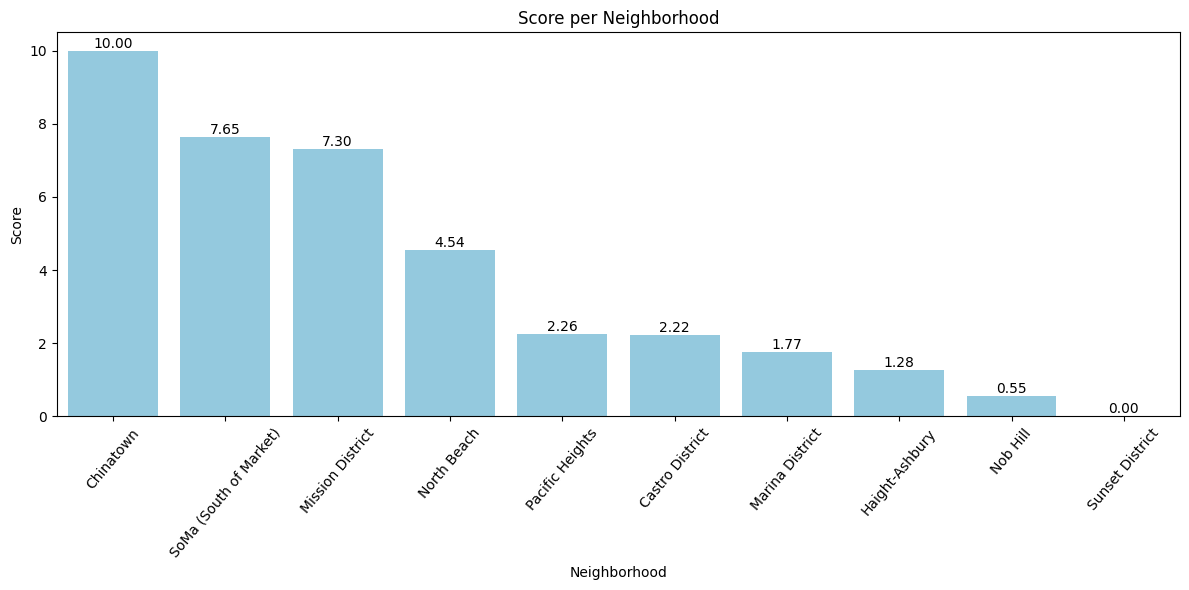

In [11]:
visu.barplot_score_per_neighborhood(merged_df)